# 数据清理

## URL 合并

In [1]:
# 导入数据文件

# here put the import lib
import os

import logging as log
import pandas as pd

from modules.logger.logger import init as logInit
from modules.logUtils.httpEvent import HttpEvent, TABLE_LABELS
from modules.fileUtils.fileUtils import getFilesByPath
from modules.config.argumentParser import argumentParser
from modules.config.configParser import getValue as getValueFromConfig

# CONFIG

TABLE_LABELS = [
    "timestamp",
    "threadId",
    "institutionId",
    "userId",
    "url",
    "method",
    "statusCode",
    "parameterType",
    "parameterName",
    "parameterValue",
    "headers",
    "name",
    "ip",
    "port",
    "vpnip"
]
# get all files.
files = getFilesByPath("data/origin")
if not files: 
    print("there no any file. recorrect the input path.")
files = files

import random

# 随机抽取 RANDOM_FILES_NUMBER 数量的日志
RANDOM_FILES_NUMBER = 0
files = random.sample(files, RANDOM_FILES_NUMBER) if RANDOM_FILES_NUMBER != 0 else files

print(len(files))
# print(files)

994


In [ ]:
# 将数据读取到 DataFrame 中

data = []
for file in files:
    count = 0
    with open(file, 'r', encoding='utf-8') as f:
        # read raw log by line.
        for line in f:
            try:
                he = HttpEvent(line)
                
                # filter user
                if he.userId == 'null': continue

                # append to Data
                data.extend([he.getSet()])
                count += 1
            except Exception as e:
                log.debug(e)
    log.info("{0} write {1} lines".format(file, count))
print(len(data), len(data[0]))
# convert List to DataFrame
# print(data[0])
df = pd.DataFrame(data = data, columns=TABLE_LABELS)
del data

In [ ]:
# 保存到 CSV
df.to_csv("data/tmp/full.csv", sep="^")
!ls -l data/tmp/full.csv

In [ ]:
# 从 CSV 读取
import pandas as pd
df = pd.read_csv('data/tmp/full.csv', sep='^')

In [ ]:
# 查看机构号
institutesDF = df.institutionId
institutes = institutesDF.value_counts()
for k, v in institutes.items():
    print(v, k)

In [ ]:
# 查看 userId
userIdDF = df.userId
users = userIdDF.value_counts()
for k, v in users.items():
    print(v, k)
print(len(users))

In [ ]:
# 输出所有 url 和次数
urlDF = df.url
urls = urlDF.value_counts()

# for k, v in urls.items():
#     print(v, k)

print(len(urls))

In [ ]:
# convert all urls
from modules.logUtils.urlFilter import urlConvert
df['url'] = df['url'].apply(urlConvert, args=(set(df.userId.values), set(df.institutionId.values),  set(df.name.values),))
# save to CSV
df.to_csv("data/tmp/converedtUrl_full.csv", sep='^')

In [ ]:
# 输出所有 url 和次数
urlDF = df.url
urls = urlDF.value_counts()

# for k, v in urls.items():
#     print(v, k)

print(len(urls))

In [ ]:
# delete bug log
df = df.drop(index=(df.loc[(df.name=='何群辉')].index))
# delete unused log
df = df.drop(index=(df.loc[(df.header=="null")].index))
# delete unused column
df = df.drop(['threadId', 'statusCode', 'parameterType'], axis=1)

In [ ]:
# Sort by userId primary key, with time as the secondary key
df.sort_values(by=['userId', 'timestamp'])

In [ ]:
df.to_csv("data/tmp/baseDataSet.csv", sep="^")

## URL 映射表制作

In [ ]:
urlSet = set(df.url.values)
urlToIndex = {url:i.__str__() for i, url in enumerate(urlSet)}
urlIndexToUrl = {i.__str__():url for i, url in enumerate(urlSet)}
print(len(urlToIndex), len(urlIndexToUrl))
# print(urlIndexToUrl)
import json
import os
if not os.path.exists('data/url'):
    os.makedirs('data/url')
    
def writeJson(filename, dic):
    with open(filename,'a', encoding="utf-8") as outfile:
        json.dump(dic,outfile,ensure_ascii=False)

writeJson("data/url/urlToIndex.json", urlToIndex)
writeJson("data/url/urlIndexToUrl.json", urlIndexToUrl)

In [ ]:
# read json to dict
def readJson(filename):
    with open(filename, "r", encoding="utf-8") as target:
        return json.load(target)
x = readJson('data/url/urlToIndex.json')
print(len(x))

## 会话识别

In [ ]:
def generateSession(hes: pd.DataFrame):
    #########################################################
    # TODO: simply save the index of url, and drop others.
    #########################################################
    
    sessions = []
    
    # read by line
    paths = []
    lastHeaderKey = ""
    lastHEDate = 0.0
    threshold = 0
    print(type(hes.timestamp))
    
#     for he in hes.itertuples():
#         #  get session key in headers       
#         headersJSON = json.loads(he.header)
#         flag = False
#         for header in headersJSON:
#             flag = True if header['value']==lastHeaderKey else False
            
#         if not flag and float(he.timestamp) - lastHEDate > threshold:
#             # start a new session
#             if paths:
#                 sessions.append("-".join([urlToIndex[url] for url in paths]))
#             paths.clear()
#         ############
#         print(he.timestamp, he.header, float(he.timestamp) - lastHEDate)
#         ############
            
#         # update paths 
#         paths.append(he.url)
#         lastHeaderKey = headersJSON[0]['value']
#         lastHEDate = float(he.timestamp)
#     sessions.append("-".join([urlToIndex[url] for url in paths]))
    return sessions

        
for userId, indexs in df.groupby('userId').groups.items():
    tmpSessions = generateSession(df.loc[indexs])
    print(tmpSessions)
    break

In [ ]:
headers = '''[{"httpOnly":false,"maxAge":-1,"name":"Authorization","secure":false,"value":"aTrSU0S4j6YQ","version":0}, {"httpOnly":false,"maxAge":-1,"name":"Authorization","secure":false,"value":"aTrSU0S4j654","version":0}]'''
# print(headers)
x = json.loads(headers)
print(x[0]['value'])


In [ ]:
paths = ['/fa/commoncore/todoCommonCore/remoteGetTotalTodoNum', '/portal/shortcutconfig/getConfigCompletion', '/portal/menus/mine/pc', '/portal/menus', '/portal/shortcutconfig/getConfigCompletion', '/portal/menus', '/portal/userusages', '/portal/menus/url', '/portal/dictionary/codes/code/code', '/portal/dictionary/codes/code/code', '/portal/dictionary/codes/code/code', '/portal/dictionary/codes/code/code', '/portal/menus/mine/pc', '/portal/shortcutconfig/getConfigCompletion', '/portal/menus/url', '/portal/dictionary/codes/code/code', '/portal/dictionary/codes/code/code', '/portal/dictionary/codes/code/code', '/portal/menus', '/portal/dictionary/codes/code/code', '/portal/userusages', '/pm/commoncore/todoCommonCore/getPmTotalPendingCount', '/od/workflow/getToDoList', '/od/tOdQpjOrgids/querySignProcess', '/od/tOdArchivesOutOrgids/getByOutTurnover', '/od/tOdArchivesOutOrgids/getByDocumentTypeTwo', '/od/tOdQpjOrgids/getBySignType', '/od/tOdArchivesInOrgids/queryInProcess', '/od/tOdArchivesInOrgids/getByInTypeCount', '/od/workflow/getToDoList', '/od/workflow/getAllTodoNumber', '/od/workflow/getToDoList', '/od/arp24Controller/getSsoURL', '/od/odRolePromissConfig/findAll', '/od/tOdFlowDefined/findAllValidChildByOdType', '/od/tOdQpjOrgids/getQueryList', '/od/arp24Controller/getSsoURL', '/od/odRolePromissConfig/findAll', '/od/tOdFlowDefined/findAllValidChildByOdType', '/od/tOdQpjOrgids/getQueryList', '/hr/thrpeople/', '/fin/arBill/getArBillAllTODOCount']
# for url in paths:
#     print(url)

pathss = "-".join([urlToIndex[url] for url in paths])
print(pathss)

In [ ]:
['441-237', '1298', '463', '237', '463', '540', '1017', '346', '346-346', '346', '1298', '237', '1017', '346', '346', '346', '463-346', '540-1537-409-771-197-207-1199-1018-594-409-1013-409-823-110-691-1217-823-110-691-1217-1341-6']

In [ ]:
print()

In [ ]:
df.url.sort_values()

## URL 原数据展示

In [39]:
df.url.value_counts()

/od/workflow/getFlowStepInfo                                                                                     226109
/od/workflow/getToDoList                                                                                          84223
/fin/arBillAssembly/getRefInfoList                                                                                53779
/portal/menus                                                                                                     50816
/fin/arBillTravel/findGwHomeTicketDataById                                                                        44698
                                                                                                                  ...  
/fin/arBill/addPrintTimes/AC1EDE1EFFFFFFFFFF8002EDFFFFA2A1                                                            1
/od/workflow/queryThroughLastActor/52841/manualActivity6/manualActivity5                                              1
/fa/commoncore/uniqueValidate/uniqueVali

## URL 提纯展示

In [43]:
# URL 提纯
df['url'] = df['url'].apply(urlConvert, args=(set(df.userId.values), set(df.institutionId.values),  set(df.name.values),))
df.url.value_counts()

/od/workflow/getFlowStepInfo                                     226109
/od/workflow/getToDoList                                          84223
/portal/dictionary/codes/code/code                                61164
/fin/arBillAssembly/getRefInfoList                                53779
/portal/menus                                                     50816
                                                                  ...  
/pm/exebudget/exeBudgetHist/hash/241711_820/241711_820/create         1
/hr/orgUnits/updateTHOrgUnit/THOrgUnit/2020-08-24/454/35/32/0         1
/fin/rmPrepareClaimList/exportClaim                                   1
/fa/asset/assetReturn/remoteGetCurrenUserReturnApplyInfo/hash         1
/pm/exebudget/exeBudgetHist/hash/241711_817/241711_817/create         1
Name: url, Length: 1556, dtype: int64

In [45]:
fsd = pd.read_csv("data/tmp/baseDataSet.csv", encoding="utf-8", sep="^")

/opt/conda/envs/persona/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
fsd

,Unnamed: 0,timestamp,institutionId,userId,url,method,parameterName,parameterValue,headers,name,ip,port,vpnip
0,0,1.597277e+09,310111,b2cb40368ffd4c568d28e5daf0341d36,/fa/commoncore/todoCommonCore/remoteGetTotalTo...,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",周青松,159.226.99.40,0,0
1,1,1.597277e+09,310111,6fc9b7ec699f41e3b8d5a96635184f47,/fa/commoncore/todoCommonCore/remoteGetTotalTo...,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",周庆华,159.226.99.35,0,0
2,2,1.597277e+09,310111,b2cb40368ffd4c568d28e5daf0341d36,/fa/commoncore/todoCommonCore/remoteGetTotalTo...,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",周青松,159.226.99.40,0,0
3,3,1.597277e+09,310111,b2cb40368ffd4c568d28e5daf0341d36,/fa/commoncore/todoCommonCore/remoteGetTotalTo...,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",周青松,159.226.99.40,0,0
4,4,1.597278e+09,310111,76a720f4c8b345b2a79a24dcaf22e862,/fa/commoncore/todoCommonCore/remoteGetTotalTo...,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",马玥浩,159.226.99.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857041,2424859,1.596638e+09,241711,241711-1037,/fin/arBill/getArBillAllTODOCount,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",胡笑然,223.104.3.171,0,0
1857042,2424860,1.596638e+09,241711,241711-3969,/fin/arBill/getArBillAllTODOCount,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",董超,219.142.146.23,0,0
1857043,2424861,1.596638e+09,241711,241711-3969,/fin/arBill/getArBillAllTODOCount,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",董超,219.142.146.23,0,0
1857044,2424862,1.596642e+09,241711,241711-3870,/fin/arBill/getArBillAllTODOCount,GET,[],[],"[{""httpOnly"":false,""maxAge"":-1,""name"":""Authori...",韩瑞丁,120.244.178.207,0,0


In [54]:
# sum = 0
# count = 0
# dic = {}
# with open('data/dataset/paths.csv', 'r') as f:
#     flag = True
#     for line in f:
#         if flag:
#             flag = False
#         else:
#             urls = line.split(',')[0]
#             dic[len(urls)] = 1 if len(urls) not in dic else dic[len(urls)] + 1   
# print(dic)

pathDF = pd.read_csv('data/dataset/paths.csv')

In [71]:
pathDF['Unnamed: 0'] = pathDF['Unnamed: 0'].rename('paths')
pathDF['len'] = pathDF['Unnamed: 0'].apply(lambda x: len(x.split('-')))

## session中具有相同路径长度的数量

In [119]:
di = pathDF.len.value_counts()
di = di[:100]
di

19    781
16    462
20    291
17    255
15    234
     ... 
4      53
88     53
90     53
2      52
1      52
Name: len, Length: 100, dtype: int64

In [77]:
import matplotlib.pyplot as plt

In [105]:
print(co)

Series([], Name: len, dtype: int64)


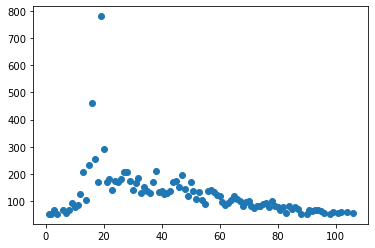

In [120]:
plt.scatter(di.keys(), di.values)

In [91]:
di.keys()
di.values

array([781, 462, 291, 255, 234, 209, 208, 208, 207, 194, 186, 179, 179,
       172, 172, 172, 171, 171, 171, 171, 170, 169, 165, 152, 151, 143,
       141, 141, 140, 138, 137, 137, 136, 135, 134, 133, 133, 129, 129,
       129, 127, 126, 120, 119, 118, 118, 106, 106, 105, 103, 102, 101,
       100,  98,  97,  95,  94,  94,  92,  89,  88,  85,  85,  82,  82,
        82,  81,  80,  80,  79,  79,  78,  78,  77,  75,  71,  70,  68,
        67,  66,  65,  65,  65,  65,  62,  61,  60,  60,  58,  56,  56,
        55,  54,  54,  53,  53,  53,  53,  52,  52,  52,  48,  48,  48,
        48,  47,  47,  46,  45,  45,  44,  43,  43,  43,  42,  42,  41,
        41,  40,  39,  39,  38,  37,  37,  36,  35,  34,  34,  34,  33,
        33,  33,  33,  31,  31,  31,  31,  31,  31,  30,  30,  30,  30,
        28,  28,  27,  27,  27,  27,  26,  26,  25,  25,  25,  25,  24,
        24,  23,  23,  23,  22,  22,  22,  22,  22,  22,  22,  22,  21,
        21,  20,  20,  20,  20,  20,  19,  19,  18,  18,  17,  1